In [1]:
using Plots
using ForwardDiff
using LinearAlgebra
using QuadGK
using Test

In [2]:
include("src/plotters.jl")
include("src/interpolation.jl")
include("src/linesearch.jl")
include("src/transform.jl")
include("src/projection.jl");

## Test of Type Stability

In [118]:
function l2_gradient(q, r)
    # Get the derivatives of the curves q, r, and compute the gradient of the cost function
    qdt(t) = ForwardDiff.derivative(q, t)
    rdt(t) = ForwardDiff.derivative(r, t)
#     diff_norm = l2_distance(q, r)
    function (t)
        return r(t)⋅qdt(t) - q(t)⋅rdt(t)  # /diff_norm
    end
end 


# Define my test functions
c1(t) = [t, 0]
ψ(t) = 0.5t^2 + 0.5t
c2(t) = [0.9t^2 + 0.1t, 0.]



# ... and their derivatives
c1dt(t) = ForwardDiff.derivative(c1, t)
c2dt(t) = ForwardDiff.derivative(c2, t)
ψdt(t) = 1.8t + 0.1 

# And get the q-maps of my test curves
q = Q_transform(c1, c1dt)
r = Q_transform(c2, c2dt)


# Get the derivatives of the curves q, r, and compute the gradient of the cost function
qdt(t) = ForwardDiff.derivative(q, t)
rdt(t) = ForwardDiff.derivative(r, t)

∇E = l2_gradient(q, r)

#233 (generic function with 1 method)

## Start Visualization

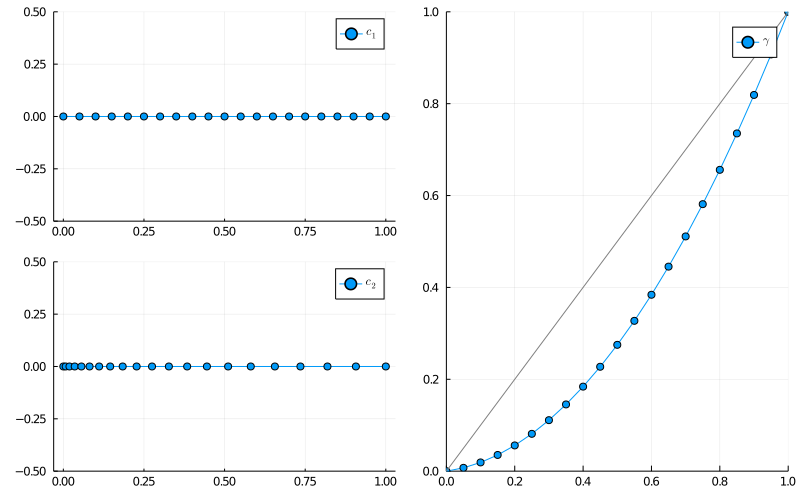

In [4]:
# Create grid of points to evaluate curves, and plot
X = 0:0.05:1
Xfine = 0:0.005:1


# Plot each of the curves, and collect into a single figure
p1 = plot_curve(c1, X, shape=:circle, ylims=(-0.5, 0.5), label="\$c_1\$")
p2 = plot_curve(c2, X, shape=:circle, ylims=(-0.5, 0.5), label="\$c_2\$")
p3 = plot(ψ, X, shape=:circle, label="\$\\gamma\$")
plot!(x -> x, X, width=1., color=:grey, xlims=(0,1), ylims=(0,1), label=:none)

# Collect and plot as a single figure
l = @layout [[a;b] c]
plot(p1, p2, p3, layout=l, size=(800, 500))

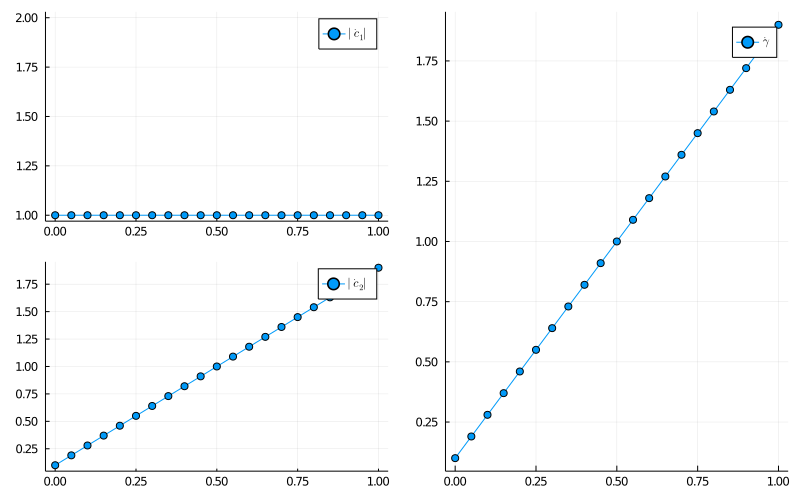

In [5]:
# Plot each of the curves, and collect into a single figure
p1 = plot(x -> norm(c1dt(x)), X, shape=:circle, label="\$|\\dot c_1|\$")
p2 = plot(x -> norm(c2dt(x)), X, shape=:circle, label="\$|\\dot c_2|\$")
p3 = plot(ψdt, X, shape=:circle, label="\$\\dot \\gamma\$")

l = @layout[[a;b] c]

plot(p1, p2, p3, layout=l, size=(800, 500))

## Q-Transform 

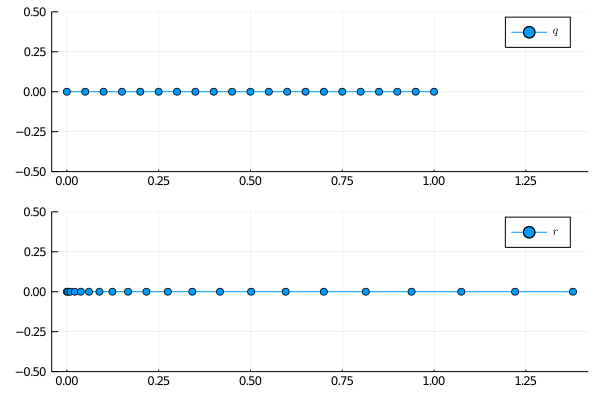

In [6]:
# Assert that the q-transform is properly implemented (by checking composition)
@test all(r.(X) ≈ (x -> sqrt(ψdt(x)) * q(ψ(x))).(X))


# Plot each of the curves, and collect into a single figure
p1 = plot_curve(q, X, shape=:circle, ylims=(-0.5, 0.5), label="\$q\$")
p2 = plot_curve(r, X, shape=:circle, ylims=(-0.5, 0.5), label="\$r\$")
plot(p1, p2, layout=(2,1), link =:x)

## Various Approaches for Gradient Interpolation

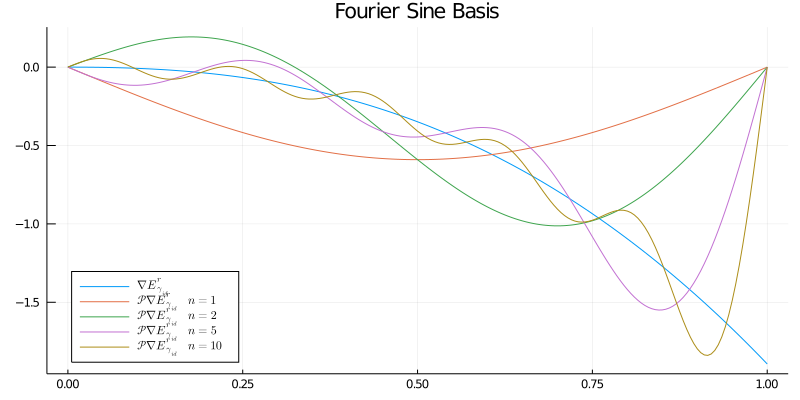

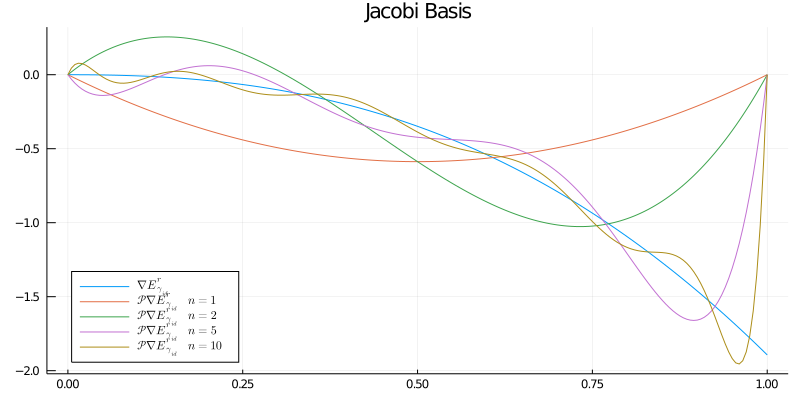

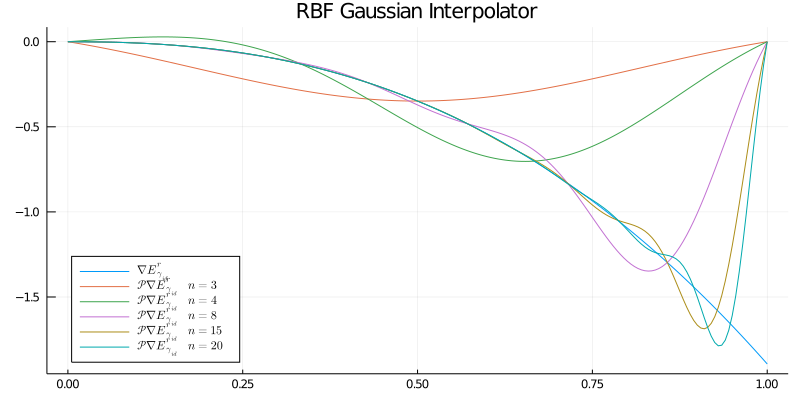

In [7]:
# Plot the gradient, and the projections with fourier basis
p = plot(∇E, Xfine, label="\$\\nabla E^r_{\\gamma_{id}}\$", size=(800, 400), title="Fourier Sine Basis")
for N in [1, 2, 5, 10]
    projE = project(∇E, [x -> √2 * sin(n*π*x) for n in 1:N])
    plot!(projE, Xfine, label="\$\\mathcal{ P }\\nabla E^r_{\\gamma_{id}}\\quad n=$N\$", legend=:bottomleft)
end
display(p)

# Plot the gradient, and the projection with Jacobi basis
p = plot(∇E, Xfine, label="\$\\nabla E^r_{\\gamma_{id}}\$", size=(800, 400), title="Jacobi Basis")

for N in [1, 2, 5, 10]
    projE = project(∇E, basis_jacobi_polynomials(N))
    plot!(projE, Xfine, label="\$\\mathcal{ P }\\nabla E^r_{\\gamma_{id}}\\quad n=$N\$", legend=:bottomleft)
end
display(p)

# Plot the gradient, and the projection with Jacobi basis
p = plot(∇E, Xfine, label="\$\\nabla E^r_{\\gamma_{id}}\$", size=(800, 400), title="RBF Gaussian Interpolator")
for N in [3, 4, 8, 15, 20]
    interpE = interpolate(∇E, N)
    plot!(interpE, Xfine, label="\$\\mathcal{ P }\\nabla E^r_{\\gamma_{id}}\\quad n=$N\$", legend=:bottomleft)
end
display(p)

### Error Comparison for Various Interpolation Approaches

  1.279587 seconds (4.87 M allocations: 301.148 MiB, 2.78% gc time)
  0.126756 seconds (466.12 k allocations: 28.641 MiB, 4.51% gc time)
  0.249878 seconds (612.83 k allocations: 35.441 MiB, 2.40% gc time)


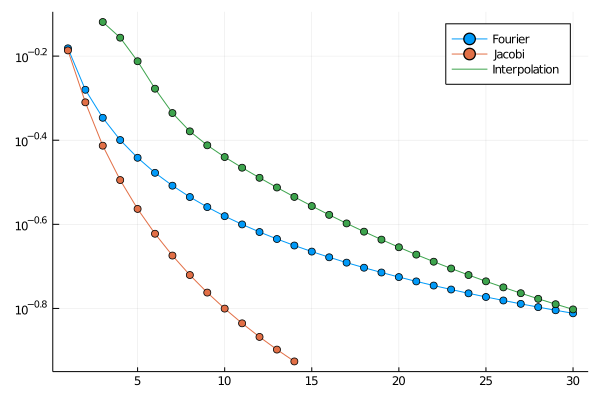

In [8]:
function projection_error_fourier(f, nmax)
    error = Array{Float64}(undef, nmax)
    for N in 1:nmax
        projf = project(f, basis_fourier_sine(N))
        error[N] = l2_distance(f, projf)
    end
    return error
end


function projection_error_jacobi(f, nmax)
    error = Array{Float64}(undef, nmax)
    for N in 1:nmax
        projf = project(f, basis_jacobi_polynomials(N))
        error[N] = l2_distance(f, projf)
    end
    return error
end

function interpolation_error_gaussian(f, nmax)
    error = Array{Float64}(undef, nmax)
    error[1:2] .= NaN
    for N in 3:nmax
        interpf = interpolate(f, N, param=10.)
        error[N] = l2_distance(f, interpf)
    end
    return error
end


projection_error_fourier(∇E, 2)
projection_error_jacobi(∇E, 2)
interpolation_error_gaussian(∇E, 2)

@time error_fourier = projection_error_fourier(∇E, 30)
plot(error_fourier, shape=:circle, label="Fourier", yscale=:log10)

@time error_jacobi = projection_error_jacobi(∇E, 14)
plot!(error_jacobi, shape=:circle, label="Jacobi")

@time error_interp = interpolation_error_gaussian(∇E, 30)
plot!(error_interp, shape=:circle, label="Interpolation")

## Putting it All Together

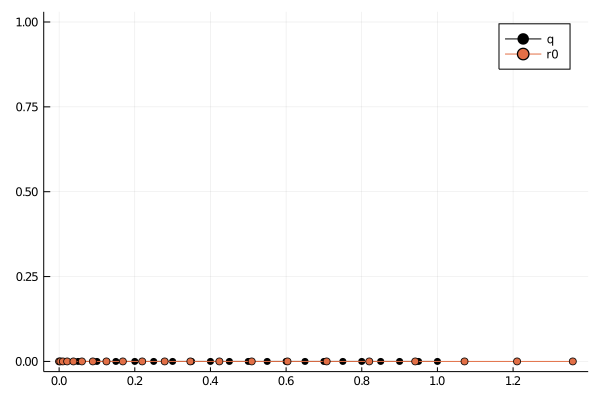

In [42]:
function plot_comparison(r, label; kwargs...)
    plot_curve(q, X, color="black", label="q", shape=:circle; kwargs...)
    plot_curve!(r, X, label=label, shape=:circle)
end
display(plot_comparison(r, "r0"))

In [43]:
function Q_reparametrization(q, γ)
    γdt(t) = ForwardDiff.derivative(γ, t)
    function (t)
        return √(norm(γdt(t))) * q(γ(t))
    end
end

Q_reparametrization (generic function with 1 method)

In [92]:
include("src/linesearch.jl")

max_step_length

In [105]:
s1(t) = [cos(2π*t), sin(2π*t)]

s1 (generic function with 1 method)

In [109]:
s3 = s1 ∘ ψ

#62 (generic function with 1 method)

In [ ]:
plot_`

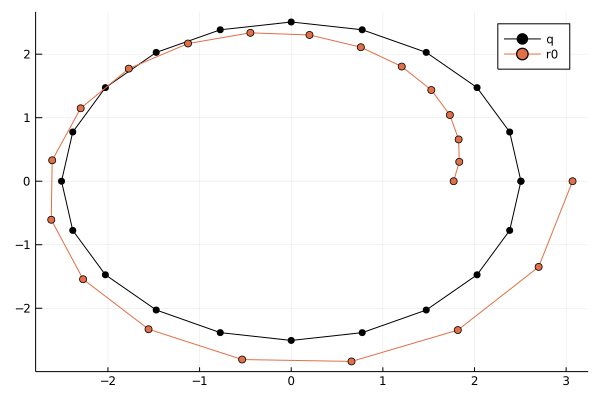

Iter    0 Error 1.4546315349e+00
Iter    1 Error 1.4546315349e+00 εmax: 2.7641030976e-03 ε: 2.7641030976e-03 ||dγ||: 4.5100888131e+01
Iter    2 Error 1.2042202812e+00 εmax: 4.2624089270e-03 ε: 2.5169098473e-03 ||dγ||: 3.8277710791e+01
Iter    3 Error 9.8694726434e-01 εmax: 2.4619461329e-03 ε: 1.9941763677e-03 ||dγ||: 2.9435359995e+01
Iter    4 Error 6.9771053965e-01 εmax: 1.5901059204e-03 ε: 1.1591872160e-03 ||dγ||: 2.4876803286e+01
Iter    5 Error 5.9580387775e-01 εmax: 2.0462885629e-03 ε: 1.2083129335e-03 ||dγ||: 1.9392834752e+01
Iter    6 Error 6.1451840894e-01 εmax: 2.4896481354e-03 ε: 7.8127796543e-04 ||dγ||: 1.6482981708e+01
Iter    7 Error 5.8127618475e-01 εmax: 8.0498154557e-03 ε: 1.8415395748e-03 ||dγ||: 5.1550294101e+00
Iter    8 Error 6.1691097475e-01 εmax: 3.9914783862e-03 ε: 5.9909949267e-04 ||dγ||: 1.0505932310e+01
Iter    9 Error 5.9728035577e-01 εmax: 2.5458590511e-01 ε: 2.0307412108e-02 ||dγ||: 1.6206848074e-01
Iter   10 Error 6.0592914551e-01 εmax: 7.9179341232e-03 ε:

In [124]:
N = 5

# And get the q-maps of my test curves
# q = Q_transform(c1, c1dt)
# r = Q_transform(c2, c2dt)
q = Q_transform(s1)
r = Q_transform(s3)
display(plot_comparison(r, "r0"))#, xlims=(-0.1, 1.5)))

# basis = basis_jacobi_polynomials(N)
basis = basis_fourier_sine(N)

Xcoarse = 0:0.1:1
Xfine = 0:0.01:1

plots = []

id(x) = x
ϕ = id
@printf "Iter %4d Error %12.10e\n" 0 l2_distance(q, r)

for i in 1:10
#     basis = basis_jacobi_polynomials(i)

    ∇E = l2_gradient(q, r)
    dγ = project(∇E, basis)
    
    εmax = max_step_length(dγ)
    ε = backtracking(q, r, dγ, εmax, ρ=0.9, c=0.1)
#     println("Iter $i. L2 Inner Product", l2_inner_product(∇E, dγ))
#     ε = εmax / 2.
#     println("εmax: $εmax, ε: $ε, ||dγ|| = $(l2_norm(dγ))")
    
    @printf "Iter %4d Error %12.10e εmax: %12.10e ε: %12.10e ||dγ||: %12.10e\n" i l2_distance(q, r) εmax ε l2_norm(dγ)
    
    γ(x) = x - ε * dγ(x)
    ϕ = ϕ ∘ γ
    
    p1 = plot(∇E, Xfine, title="Iter $i: L2- and projected gradient", label="∇E")#, ylims=(-2., 2.))
    plot!(dγ, Xfine, label="dγ")
    
    p2 = plot(ϕ, Xfine, title="Iter $i: First Reparametrization", legend=false)
    plot!(γ, Xfine, linestyle=:dash, color="red", linewidth=0.5)
    plot!(ψ, Xfine, linestyle=:dash, color="black")
    
    r = Q_reparametrization(r, γ)
    
    p3 = plot_comparison(r, "r$i")#, xlims=(-0.1, 1.5))
    
    p = plot(p1, p2, p3, layout=@layout[a b; c], size=(900, 600))
    push!(plots, p)
#     display(p)
end

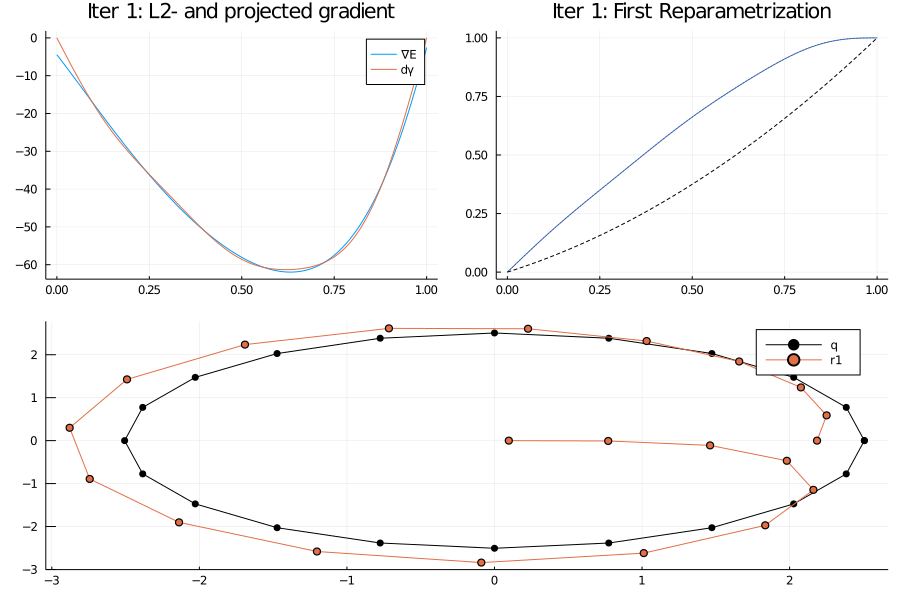

In [126]:
plots[1]

┌ Info: Saved animation to 
│   fn = /home/jorgen/.julia/dev/Reparam/tmp.gif
└ @ Plots /home/jorgen/.julia/packages/Plots/4EfKl/src/animation.jl:104


Plots.AnimatedGif("/home/jorgen/.julia/dev/Reparam/tmp.gif")
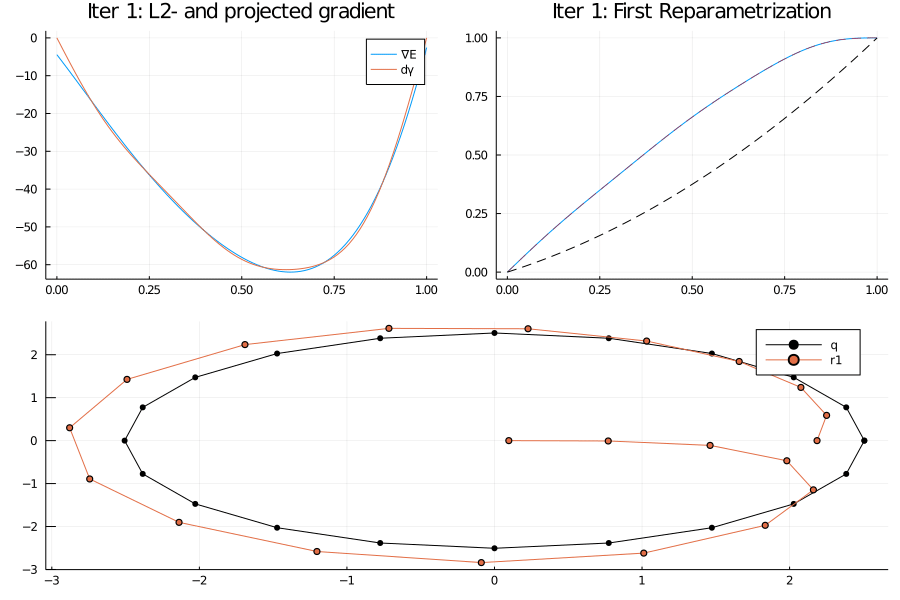

In [125]:
anim = @animate for p in plots
    plot(p)
end
gif(anim, fps=10)